Install libraries

In [2]:
# %pip install selenium beautifulsoup4 webdriver-manager
# %pip install rake-nltk spacy keybert transformers torch langdetect matplotlib seaborn
# %python -m spacy download en_core_web_sm
# %choco install googlechrome


Import Libraries

In [3]:
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from datetime import datetime, timedelta
import time
import nltk
from nltk.tokenize import sent_tokenize
import re
import os
import json
import spacy
import hashlib
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from langdetect import detect

In [4]:
# Download required NLTK resources and Data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Azmarah
[nltk_data]     Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Azmarah
[nltk_data]     Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Azmarah
[nltk_data]     Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Azmarah
[nltk_data]     Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Azmarah
[nltk_data]     Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Scraping the Content

In [5]:
# Set up Selenium WebDriver options
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Define date range for scraping
start_date = datetime(2024, 11, 10)
end_date = datetime(2024, 11, 20)

# Cache directory
CACHE_DIR = "scraped_cache"

# Ensure cache directory exists
os.makedirs(CACHE_DIR, exist_ok=True)

# Cache file path (using URL as filename)
def get_cache_file_path(url):
    hash_name = hashlib.md5(url.encode()).hexdigest()  # Unique, short hash
    return os.path.join(CACHE_DIR, f"{hash_name}_cache.json")

# Cache expiration (e.g., cache lasts for 2 minutes)
CACHE_EXPIRATION_MINUTES = 2

# Check if cache is valid (not expired)
def is_cache_valid(cache_file):
    if os.path.exists(cache_file):
        file_mtime = datetime.fromtimestamp(os.path.getmtime(cache_file))
        return (datetime.now() - file_mtime) <= timedelta(minutes=CACHE_EXPIRATION_MINUTES)
    return False

# Load cached content from file
def load_cache(cache_file):
    with open(cache_file, 'r', encoding='utf-8') as f:  # Set encoding to UTF-8
        return json.load(f)

# Save scraped content to cache file
def save_to_cache(cache_file, data):
    with open(cache_file, 'w', encoding='utf-8') as f:  # Set encoding to UTF-8
        json.dump(data, f, ensure_ascii=False)  # Preserve Unicode characters


def scrape_content(driver):
    """
    Scrapes main content from the current page.
    """
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Remove <header>, <footer>, and <form> tags from main content
    for tag in soup(['header', 'footer', 'form']):
        tag.decompose()

    # Target main content elements
    main_content = soup.find_all(['article', 'section', 'main', 'body'])
    page_text = ' '.join((element.get_text(separator=" ", strip=True)) for element in main_content)
    return page_text

def navigate_to_next_page(driver):
    """
    Attempts to navigate to the next page.
    """
    try:
        next_button = driver.find_element(By.LINK_TEXT, 'Next')
        driver.execute_script("arguments[0].click();", next_button)
        time.sleep(2)
        return True
    except:
        return False

visited_links = set()

def scrape_linked_pages(soup, base_url):
    """
    Extracts and scrapes linked pages found on the current page.
    """
    page_links = [a['href'] for a in soup.find_all('a', href=True)]
    linked_page_texts = []

    for link in page_links:
        # Handle relative URLs
        if link.startswith("/"):
            full_url = base_url + link
        elif base_url in link:
            full_url = link
        else:
            continue

        if full_url in visited_links:
            continue  # Skip already visited links
        visited_links.add(full_url)

        driver.get(full_url)
        time.sleep(1)
        linked_page_texts.append(scrape_content(driver))

    return linked_page_texts

# Main scraping loop
def main_scrape(url):
    """
    Main function to scrape content from pages and linked pages within a specified date range.
    """
    driver.get(url)
    base_url = re.match(r'^https?://[^/]+', url).group(0)
    all_page_content = []
    page_number = 1

    try:
        while True:
            print(f"Scraping page {page_number}...")

            # Scrape main page content
            page_text = scrape_content(driver)
            page_sentences = sent_tokenize(page_text)
            all_page_content.append(page_sentences)

            # Scrape linked pages
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            linked_texts = scrape_linked_pages(soup, base_url)

            # Append linked pages' text
            for linked_text in linked_texts:
                linked_sentences = sent_tokenize(linked_text)
                all_page_content.append(linked_sentences)

            # Check if there's a next page
            if not navigate_to_next_page(driver):
                break

            page_number += 1

    finally:
        driver.quit()

    # Return the scraped content
    return all_page_content

# Define target URL and initiate scraping
url = "https://www.hnbfinance.lk/"
# url = "https://www.hnb.lk/"

# Cache file path
cache_file = get_cache_file_path(url)

# Load cached content if available
if is_cache_valid(cache_file):
    print("Loading content from cache...")
    scraped_content = load_cache(cache_file)
else:
    print("Scraping content...")
    scraped_content = main_scrape(url)
    # Save the scraped content to cache
    save_to_cache(cache_file, scraped_content)

# Initialize an empty list to store all sentences
all_sentences = []

# Print the scraped content and simultaneously append sentences to `all_sentences`
print("\n--- Scraped Content ---")
for page, sentences in enumerate(scraped_content, start=1):
    print(f"\n--- Page {page} Content (Sentence-wise) ---")
    for sentence in sentences:
        print(f"  {sentence}")
        all_sentences.append(sentence)  # Append each sentence to the list

# Now `all_sentences` contains all sentences from the scraped content
print("\n--- All Sentences Collected ---")
print(all_sentences)


Scraping content...
Scraping page 1...

--- Scraped Content ---

--- Page 1 Content (Sentence-wise) ---
  Services That Offer You Convenience and Flexibility Leasing explore Fixed Deposits explore Savings explore Relax - Personal Loans explore Micro Loans explore Housing Loans explore Business Loans explore Gold Loans explore HNB Finance PLC Strength Born of Strength HNB Finance is a subsidiary of Hatton National Bank PLC and continues to operate with an unblemished record of almost two decades as a leader in the finance industry with a diverse portfolio of financial products and services.
  Products to Help You Grow Shaping your future with products that encourage growth HNB Finance General Savings explore HNB Finance Leasing explore HNB Finance Housing Financial Solution explore HNB Finance Fixed Deposits explore HNB Finance Miyulasi Women's Savings explore HNB Finance General Savings explore HNB Finance Leasing explore HNB Finance Housing Financial Solution explore HNB Finance Fixed

Text Cleaning

In [ ]:

# Initialize SpaCy model for NER
nlp = spacy.load("en_core_web_sm")

if not isinstance(scraped_content, str):
        text = str(scraped_content)

# Step 1: Run NER
doc = nlp(text)

# Create a list of identified entities
entities = [ent.text for ent in doc.ents]

# Step 1: Remove phone numbers
clean_text = re.sub(r'\+?\d[\d\(\)\- ]{7,}\d', '.', text, flags=re.IGNORECASE)

# Step 2: Remove emails
clean_text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '.', clean_text, flags=re.IGNORECASE)

# Step 3: Remove URLs
clean_text = re.sub(r'http[s]?://\S+|www\.[\S]+', '.', clean_text, flags=re.IGNORECASE)

# Step 5: Remove time-related words (am, pm, and time format)
clean_text = re.sub(r'\b(?:am|pm|a\.?m\.?|p\.?m\.?|am to pm|a\.m to p\.m|\.?a\.m|\.?p\.m)\b', '', clean_text, flags=re.IGNORECASE)

# Step 6: Remove currency symbols
clean_text = re.sub(r'\b(rs\.|€|\$|£|₹|¥|lkr)\b', '', clean_text, flags=re.IGNORECASE)

# Step 7: Remove specific time patterns like "8.30am to 5.00pm"
clean_text = re.sub(r'\b\d{1,2}[:.]?\d{2}(am|pm)\s?to\s?\d{1,2}[:.]?\d{2}(am|pm)\b', '.', clean_text, flags=re.IGNORECASE)

# Step 8: Remove addresses (like "07, nilwala building, morawaka")
clean_text = re.sub(r'\d{1,4}[\w\s,\.]+(?:building|branch|street|road|district|court|office)', '', clean_text, flags=re.IGNORECASE)

# Step 9: Remove HTML tags
clean_text = re.sub(r'<[^>]*>', '.', clean_text, flags=re.IGNORECASE)
clean_text = re.sub(r'[\n\t\r]', '.', clean_text, flags=re.IGNORECASE)

# List of common titles to remove
titles_pattern = r'\b(mr|mrs|ms|miss|dr|prof|sir|madam|dame|lady|lord|Mr|Dr)\.?\s*'

# Step 1: Remove titles using regex
clean_text = re.sub(titles_pattern, ' ', clean_text, flags=re.IGNORECASE)

# Step 1: Remove unwanted patterns like 'th... Read more' or '... Read more'
clean_text = re.sub(r'\b\w{2,4}\.{2,3}\s?read\smore\b', '.', clean_text, flags=re.IGNORECASE)

# Step 11: Remove non-English characters (also removes Sinhala and Tamil)
clean_text = re.sub(r'[^A-Za-z0-9\s\.,?!;:@$&%()\'"-]', '', clean_text)

# Step 12: Remove specific words like "explore" and "download"
clean_text = re.sub(r'\b(?:explore|download|Strength|Open|weekdays|Weekdays|Board|Executive|FAQ|Master|100%|Reasons)\b', '.', clean_text, flags=re.IGNORECASE)


print(clean_text)

'Services That Offer You Convenience and Flexibility Leasing . Fixed Deposits . Savings . Relax - Personal Loans . Micro Loans . Housing Loans . Business Loans . Gold Loans . HNB Finance PLC . Born of . HNB Finance is a subsidiary of Hatton National Bank PLC and continues to operate with an unblemished record of almost two decades as a leader in the finance industry with a diverse portfolio of financial products and services.', "Products to Help You Grow Shaping your future with products that encourage growth HNB Finance General Savings . HNB Finance Leasing . HNB Finance Housing Financial Solution . HNB Finance Fixed Deposits . HNB Finance Miyulasi Women's Savings . HNB Finance General Savings . HNB Finance Leasing . HNB Finance Housing Financial Solution . HNB Finance Fixed Deposits . HNB Finance Miyulasi Women's Savings . HNB Finance General Savings . Success Stories Our keen focus on entrepreneurs across the country enables us to boost SME & SSE communities to reach their full pote

NER Tags for the Scraped Content

In [ ]:
import spacy
from spacy import displacy
import pandas as pd
from tqdm import tqdm
import re
import json

# Load the pre-trained spaCy model (choose lg for better accuracy but slower performance)
nlp = spacy.load("en_core_web_sm")

### 1. Data Analysis ###
def analyze_data(data):

    # Analyze the input data to check for missing or unusual patterns.

    print("Data Sample:")
    print(data[:500])  # Show a sample of the data
    print("\nData Length:", len(data))
    print("Number of Words:", len(data.split()))
    print("Number of Sentences:", len(re.split(r'[.!?]', data)))
    return

### 3. Feature Extraction: Tokenization and NER ###
def extract_entities(data, batch_size=10):

    # Perform NER on the preprocessed text and extract features.

    # Tokenize and analyze NER in batches for efficiency
    docs = list(tqdm(nlp.pipe(data, batch_size=batch_size), total=len(data)))

    results = []
    for doc in docs:
        entities = [[ent.text, ent.label_, ent.start_char, ent.end_char] for ent in doc.ents]
        results.append({"Sentence": doc.text, "entities": entities})
    return results

### 4. Exporting Results ###
def export_results(results, output_file="ner_results.csv"):

    rows = []
    for result in results:
        rows.append({
            "Sentence": result["Sentence"],
            "entities": json.dumps(result["entities"])  # Convert entities to JSON string
        })

    df = pd.DataFrame(rows)
    df.to_csv(output_file, index=False)
    print(f"NER results saved to {output_file}")

### 5. Visualization (Optional) ###
def visualize_entities(text):

    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)  # Jupyter Notebook visualization

### Complete Workflow ###
def ner_workflow(scraped_data):

    # Step 1: Data Analysis
    analyze_data(scraped_data)

    # Step 3: Segment data for large inputs (split by sentences or paragraphs)
    segments = scraped_data.split(". ")

    # Step 4: Extract NER
    results = extract_entities(segments)

    # Step 5: Save Results
    export_results(results)

    # Step 6: Visualization
    visualize_entities(". ".join(segments[:1000]))

    print("Workflow completed!")
    return


# Run the NER workflow
ner_workflow(clean_text)


Data Sample:
'Services That Offer You Convenience and Flexibility Leasing . Fixed Deposits . Savings . Relax - Personal Loans . Micro Loans . Housing Loans . Business Loans . Gold Loans . HNB Finance PLC . Born of . HNB Finance is a subsidiary of Hatton National Bank PLC and continues to operate with an unblemished record of almost two decades as a leader in the finance industry with a diverse portfolio of financial products and services.', "Products to Help You Grow Shaping your future with products that en

Data Length: 237145
Number of Words: 37032
Number of Sentences: 3081


100%|██████████| 1007/1007 [00:10<00:00, 92.44it/s] 


NER results saved to ner_results.csv


Workflow completed!


Checking for invalid input

In [ ]:
import pandas as pd
import json

# Function to load CSV and identify problematic rows
def check_entities_in_csv(csv_file):
    """
    Load a CSV file and print rows with invalid JSON in the 'entities' column.
    """
    df = pd.read_csv(csv_file)

    print("Checking for invalid 'entities' JSON...\n")

    for index, row in df.iterrows():
        sentence = row['Sentence']  # Column with sentences
        entities_value = row['entities']  # Column with entities JSON-like string

        try:
            # Attempt to parse the 'entities' column
            json.loads(entities_value)
        except json.JSONDecodeError as e:
            print(f"Error in row {index + 1}:")
            print(f"Sentence: {sentence}")
            print(f"Entities: {entities_value}")
            print(f"Error Message: {e}")
            print("-" * 80)

# Main function
def main():
    input_csv = "NER to fine tune.csv"  # Replace with your CSV file path
    check_entities_in_csv(input_csv)

# Run the main workflow
if __name__ == "__main__":
    main()


Checking for invalid 'entities' JSON...



Fine Tune the Spacy Model

In [ ]:
import spacy
from spacy.training import Example
import pandas as pd
import json

# Step 1: Load CSV data
def load_csv_data(csv_file):

    df = pd.read_csv(csv_file)
    training_data = []

    for index, row in df.iterrows():
        sentence = row['Sentence']  # Column with sentences

        try:
            entities = json.loads(row['entities'])  # Parse the entities column as JSON
        except json.JSONDecodeError as e:
            print(f"JSONDecodeError in row {index + 1}: {row['entities']}")
            raise e  # Re-raise the exception after logging

        annotations = {"entities": [(e[2], e[3], e[1]) for e in entities]}  # Format for spaCy training
        training_data.append((sentence, annotations))

    return training_data


# Step 2: Fine-Tune the spaCy NER Model
def fine_tune_ner_model(training_data, output_dir, iterations=500):

    # Load the pre-trained spaCy model
    nlp = spacy.load("en_core_web_sm")

    # Get the NER pipeline component
    ner = nlp.get_pipe("ner")

    # Add new labels to the NER model
    for _, annotations in training_data:
        for ent in annotations["entities"]:
            ner.add_label(ent[2])  # Add the entity label

    # Disable other components during training
    pipe_exceptions = ["ner"]
    unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

    # Training loop
    with nlp.disable_pipes(*unaffected_pipes):  # Only train the NER pipeline
        optimizer = nlp.resume_training()
        for iteration in range(iterations):
            print(f"Iteration {iteration + 1}/{iterations}")
            losses = {}
            for text, annotations in training_data:
                example = Example.from_dict(nlp.make_doc(text), annotations)
                nlp.update([example], drop=0.5, losses=losses)
            print(f"Losses: {losses}")

    # Save the fine-tuned model
    nlp.to_disk(output_dir)
    print(f"Model saved to {output_dir}")

# Step 3: Main Workflow
def main():
    # Define file paths
    input_csv = "NER to fine tune.csv"  # Replace with your CSV file path
    output_dir = "./fine_tuned_model"  # Directory to save the fine-tuned model

    # Load and prepare training data
    training_data = load_csv_data(input_csv)

    # Fine-tune the model
    fine_tune_ner_model(training_data, output_dir)

# Run the main workflow
if __name__ == "__main__":
    main()


Iteration 1/500


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Relax - Personal Loans " with entities "[(6, 20, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Miyulasi Womens Savings .', 'Home Savings Savings ..." with entities "[(0, 23, 'PRODUCT'), (28, 40, 'PRODUCT'), (74, 88,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Yalu - Children's Savings A saving scheme 

Losses: {'ner': 150.893499026021}
Iteration 2/500
Losses: {'ner': 142.79432056171342}
Iteration 3/500
Losses: {'ner': 139.85426625316717}
Iteration 4/500
Losses: {'ner': 132.79349979152298}
Iteration 5/500
Losses: {'ner': 103.96742486673483}
Iteration 6/500
Losses: {'ner': 96.18735761060256}
Iteration 7/500
Losses: {'ner': 78.0942937880927}
Iteration 8/500
Losses: {'ner': 91.200068065615}
Iteration 9/500
Losses: {'ner': 75.25410736423598}
Iteration 10/500
Losses: {'ner': 83.23534081861858}
Iteration 11/500
Losses: {'ner': 76.51619474783536}
Iteration 12/500
Losses: {'ner': 72.5364906269042}
Iteration 13/500
Losses: {'ner': 73.27506065439756}
Iteration 14/500
Losses: {'ner': 79.14157015739696}
Iteration 15/500
Losses: {'ner': 69.2835671177775}
Iteration 16/500
Losses: {'ner': 65.78106382808191}
Iteration 17/500
Losses: {'ner': 57.530720016362565}
Iteration 18/500
Losses: {'ner': 64.06496771116801}
Iteration 19/500
Losses: {'ner': 48.070942585984284}
Iteration 20/500
Losses: {'ner': 43.3

NER Tags after fine Tuning

In [ ]:
# get results from the fine tuned model

import spacy
from spacy import displacy
import pandas as pd
from tqdm import tqdm
import json
import re

# Load the fine-tuned spaCy model
nlp = spacy.load("fine_tuned_model")  # Replace with the path to your fine-tuned model

### 1. Data Analysis ###
def analyze_data(data):

    print("Data Sample:")
    print(data[:500])  # Show a sample of the data
    print("\nData Length:", len(data))
    print("Number of Words:", len(data.split()))
    print("Number of Sentences:", len(re.split(r'[.!?]', data)))
    return

### 3. Feature Extraction: Tokenization and NER ###
def extract_entities(data, batch_size=10):

    # Tokenize and analyze NER in batches for efficiency
    docs = list(tqdm(nlp.pipe(data, batch_size=batch_size), total=len(data)))

    entities = []
    for doc in docs:
        for ent in doc.ents:
            entities.append({"text": ent.text, "label": ent.label_, "start": ent.start_char, "end": ent.end_char})

    return entities

### 4. Exporting Results ###
def export_results(entities, output_file="new_ner_results.csv"):

    df = pd.DataFrame(entities)
    df.to_csv(output_file, index=False)
    print(f"NER results saved to {output_file}")

### 5. Visualization (Optional) ###
def visualize_entities(text):

    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)  # Jupyter Notebook visualization

### Complete Workflow ###
def ner_workflow(scraped_data):

    # Step 1: Data Analysis
    analyze_data(scraped_data)

    # Step 3: Segment data for large inputs (split by sentences or paragraphs)
    segments = scraped_data.split(". ")

    # Step 4: Extract NER
    entities = extract_entities(segments)

    # Step 5: Save Results
    export_results(entities)

    # Step 6: Visualization
    visualize_entities(". ".join(segments[:1000]))

    print("Workflow completed!")
    return

# Run the NER workflow using the fine-tuned model
ner_workflow(clean_text)


Data Sample:
'Services That Offer You Convenience and Flexibility Leasing . Fixed Deposits . Savings . Relax - Personal Loans . Micro Loans . Housing Loans . Business Loans . Gold Loans . HNB Finance PLC . Born of . HNB Finance is a subsidiary of Hatton National Bank PLC and continues to operate with an unblemished record of almost two decades as a leader in the finance industry with a diverse portfolio of financial products and services.', "Products to Help You Grow Shaping your future with products that en

Data Length: 237145
Number of Words: 37032
Number of Sentences: 3081


100%|██████████| 1007/1007 [00:10<00:00, 94.43it/s]


NER results saved to new_ner_results.csv


Workflow completed!


1. Most Frequently occured NER Tagged words and Saving the NER Tagged words as a Dictionary

In [ ]:
import spacy
from spacy import displacy
import pandas as pd
from tqdm import tqdm
from collections import Counter
import json
import re

# Load the fine-tuned spaCy model
nlp = spacy.load("fine_tuned_model")  # Replace with the path to your fine-tuned model

### 1. Data Analysis ###
def analyze_data(data):
    print("Data Sample:")
    print(data[:500])  # Show a sample of the data
    print("\nData Length:", len(data))
    print("Number of Words:", len(data.split()))
    print("Number of Sentences:", len(re.split(r'[.!?]', data)))
    return

### 2. Feature Extraction: Tokenization and NER ###
def extract_entities(data, batch_size=10):
    docs = list(tqdm(nlp.pipe(data, batch_size=batch_size), total=len(data)))

    entities = []
    for doc in docs:
        for ent in doc.ents:
            entities.append({"text": ent.text, "label": ent.label_, "start": ent.start_char, "end": ent.end_char})

    return entities

### 3. Calculate Top Words for Each NER Tag ###
def get_top_words_by_ner(entities, top_n=5):
    ner_words = {}
    for entity in entities:
        label = entity["label"]
        word = entity["text"]
        if label not in ner_words:
            ner_words[label] = []
        ner_words[label].append(word)

    top_words = {}
    for label, words in ner_words.items():
        word_counts = Counter(words)
        top_words[label] = [{"word": word, "count": count} for word, count in word_counts.most_common(top_n)]

    return top_words

### 4. Exporting Results ###
def export_results(entities, output_file="new_ner_results.csv"):
    df = pd.DataFrame(entities)
    df.to_csv(output_file, index=False)
    print(f"NER results saved to {output_file}")

### 5. Display Top Words ###
def display_top_words(top_words):
    print("\nTop Words by NER Tag:")
    for label, words in top_words.items():
        print(f"\nNER Tag: {label}")
        print("Word - Count")
        for word_info in words:
            print(f"{word_info['word']} - {word_info['count']}")

### 6. Visualization (Optional) ###
def visualize_entities(text):
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)

### 7. Unique Words Extraction ###
def extract_unique_words(entities):
    unique_words = set()
    for entity in entities:
        unique_words.add(entity["text"].strip())  # Add unique entities
    return unique_words


### 9. Complete Workflow ###
def ner_workflow(scraped_data):
    analyze_data(scraped_data)

    segments = scraped_data.split(". ")

    entities = extract_entities(segments)  # Extract entities
    unique_words = extract_unique_words(entities)  # Get unique words
    top_words = get_top_words_by_ner(entities)  # Get top words by NER tag

    # Optionally display top words
    display_top_words(top_words)

    print("Workflow completed!")
    return unique_words  # Return the unique words set if needed

# Run the NER workflow
unique_words = ner_workflow(clean_text)



Data Sample:
'Services That Offer You Convenience and Flexibility Leasing . Fixed Deposits . Savings . Relax - Personal Loans . Micro Loans . Housing Loans . Business Loans . Gold Loans . HNB Finance PLC . Born of . HNB Finance is a subsidiary of Hatton National Bank PLC and continues to operate with an unblemished record of almost two decades as a leader in the finance industry with a diverse portfolio of financial products and services.', "Products to Help You Grow Shaping your future with products that en

Data Length: 237145
Number of Words: 37032
Number of Sentences: 3081


100%|██████████| 1007/1007 [00:10<00:00, 93.00it/s] 


Top Words by NER Tag:

NER Tag: PRODUCT
Word - Count
Mehewera - 42
Personal Loans - 17
Gold Loans - 11
HNB Finance General Savings - 10
Micro Loans - 9

NER Tag: ORG
Word - Count
HNB FINANCE - 208
HNB Finance - 103
HNB - 88
HNB FINANCE PLC - 79
HNB Finance PLC - 28

NER Tag: DATE
Word - Count
2024 10% - 30
Saturday - 18
5 years - 9
December 12, 2023 - 8
January 08, 2024 - 7

NER Tag: GPE
Word - Count
Mehewara - 7
Merit - 2
Monthly - 1
MoneyGram - 1
Member - 1

NER Tag: PERSON
Word - Count
Anura Pathirage - 9
Eligibility Customers - 4
Co- - 2
Australia (CMA - 2
over a decade - 2

NER Tag: WORK_OF_ART
Word - Count
General Saving - 2
Audited Financial Statements - 1
General Savings - 1
General Savings Account 'HNB Finance' - 1
BestWeb.lk 2019 Gold Award for the Best Banking - 1

NER Tag: CARDINAL
Word - Count
one - 14
08:30 - 3
Three - 3
three - 2
07:00 - 2
Workflow completed!


In [ ]:
import spacy
import json
from tqdm import tqdm

# Load the fine-tuned spaCy model
nlp = spacy.load("fine_tuned_model")  # Replace with the path to your fine-tuned model

# Function to extract unique words
def extract_unique_words(scraped_data, batch_size=10):
    """
    Extract unique words using NER and save them as a list.
    """
    # Tokenize and process in batches
    segments = scraped_data.split(". ")
    docs = list(tqdm(nlp.pipe(segments, batch_size=batch_size), total=len(segments)))

    # Collect unique words
    unique_words = set()
    for doc in docs:
        for ent in doc.ents:
            unique_words.add(ent.text.strip())

    return list(unique_words)  # Convert to list format

# Save unique words to JSON
def save_unique_words_to_json(unique_words_list, output_file="ner_unique_words.json"):
    """
    Save unique words list to a JSON file.
    """
    with open(output_file, 'w') as f:
        json.dump(unique_words_list, f, indent=4)
    print(f"Unique words saved to {output_file}")

# Run the process
unique_words_list = extract_unique_words(clean_text)
save_unique_words_to_json(unique_words_list)


100%|██████████| 1007/1007 [00:10<00:00, 93.78it/s]

Unique words saved to ner_unique_words.json


Word Cloud for Most frequetly occured words in the scraped content

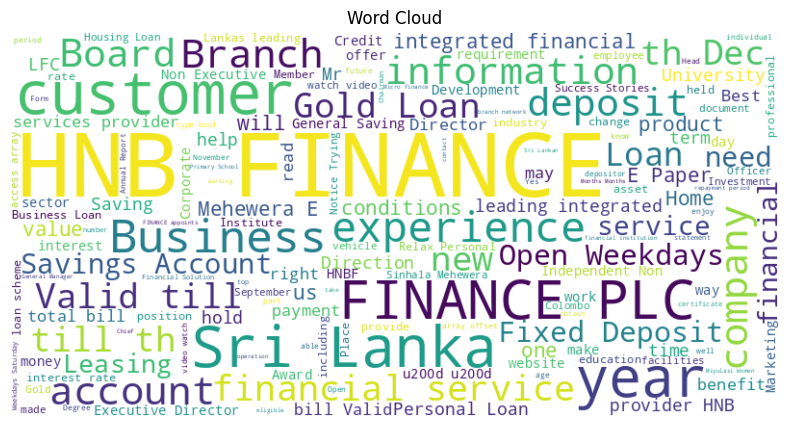

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate and display the word cloud
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axis
    plt.title("Word Cloud")
    plt.show()

# Call the function to generate the word cloud
generate_word_cloud(clean_text)

2. Further Cleaning and Word Cloud for Most frequetly occured words in the cleaned text

In [ ]:
import spacy
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter
import json
import string

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Custom stop words
custom_stop_words = [
    "monday", "friday", "saturday", "sunday", "tuesday", "wednesday", "thursday", "type", "bool", "number",
    "non", "video", "watch", "paper", "good", "day", "mr", "dr", "you", "me", "we", "us", "march",
    "january", "february", "april", "array", "value", "nas", "may", "june", "one", "bad", "july",
    "august", "september", "october", "november", "december", "weekend", "valid", "Lanka", "weekday",
    "explore", "read", "more", "continue", "cont", "open", "that", "this", "need", "well", "Mr .",
    "Mr.", "those", "why", "where", "how", "what", "these", "php", "css", "html", "line", "till",
    "their", "and", "php", "inner", "it", "months", "month", "weekdays", "get", "directions",
    "yes", "total", "no", "con", "could", "can", "would", "should", "might", "must", "may", "shall",
    "right", "left", "dec", "will", "won't", "wouldn't", "shouldn't", "couldn't", "can't",
    "cannot", "th", "nd", "ud", "e", "also", "sri", "mr", "dr", "bill", "year"
]
stop_words.update(custom_stop_words)

# Define common phrases to remove
common_phrases = [
    "read more", "explore", "download", "get started", "contact us", "terms and conditions",
    "array value", "term condition", "privacy policy", "about us", "learn more", "find out more",
    "sign up", "contact information", "Mr.", "Mr .", "mr.", "contact number", "download now",
    "log in", "click here", "talk fulf", "success story", "valid till", "mr ."
]

# Function to clean the text and maintain sentences
def further_clean_text_func(input_text):
    # Step 1: Store the original text
    original_text = input_text

    # Step 2: Remove numbers
    original_text = re.sub(r'\d+', '', original_text)  # Remove all numbers

    # Step 3: Tokenization
    doc = nlp(original_text)
    cleaned_sentences = []
    for sentence in doc.sents:
        cleaned_words = [
            token.text for token in sentence
            if (token.text.lower() not in stop_words
                and not token.is_punct
                and len(token) <= 10)  # Adjust length threshold here
        ]
        cleaned_sentences.append(' '.join(cleaned_words))

    # Step 4: Join cleaned sentences back into a single text
    cleaned_text = '. '.join(cleaned_sentences)

    return cleaned_text, original_text  # Return cleaned and original text


# Further clean the text
final_cleaned_text, original_text = further_clean_text_func(clean_text)

# Print the cleaned text for verification
print("Final Cleaned Text:")
print(final_cleaned_text)



def save_word_frequencies(text):
    # Count word frequencies
    sentences = text.split('. ')
    word_set = set()
    bigram_set = set()
    trigram_set = set()

    for sentence in sentences:
        # Remove punctuation from the sentence
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        words = sentence.split()
        word_set.update(words)  # Collect unique words
        bigram_set.update([' '.join(bi) for bi in ngrams(words, 2)])  # Collect unique bigrams
        trigram_set.update([' '.join(tri) for tri in ngrams(words, 3)])  # Collect unique trigrams

    # Combine all unique words into one flat list
    combined_words = list(word_set) + list(bigram_set) + list(trigram_set)

    # Save to a JSON file without structure
    with open('word_frequencies.json', 'w') as f:
        json.dump(combined_words, f, indent=4)

    return combined_words


# Save word frequencies, bigrams, and trigrams to a JSON file
word_frequencies = save_word_frequencies(final_cleaned_text)

print("Word frequencies, bigrams, and trigrams saved to 'word_frequencies.json'.")


Final Cleaned Text:
Services Offer Leasing. Fixed Deposits. Savings. Relax Personal Loans. Micro Loans. Housing Loans. Business Loans. Gold Loans. HNB Finance PLC. Born. HNB Finance subsidiary Hatton National Bank PLC continues operate record almost two decades leader finance industry diverse portfolio financial products services. Products Help Grow Shaping future products encourage growth HNB Finance General Savings. HNB Finance Leasing. HNB Finance Housing Financial Solution. HNB Finance Fixed Deposits. HNB Finance Miyulasi Women 's Savings. HNB Finance General Savings. HNB Finance Leasing. HNB Finance Housing Financial Solution. HNB Finance Fixed Deposits. HNB Finance Miyulasi Women 's Savings. HNB Finance General Savings. Success Stories. keen focus across country enables boost SME SSE reach full potential. HNB FINANCE immense. lives HNB FINANCE financial partner   years Therefore able business according. enjoy benefit obtaining money business saving able loan without guarantors Sw

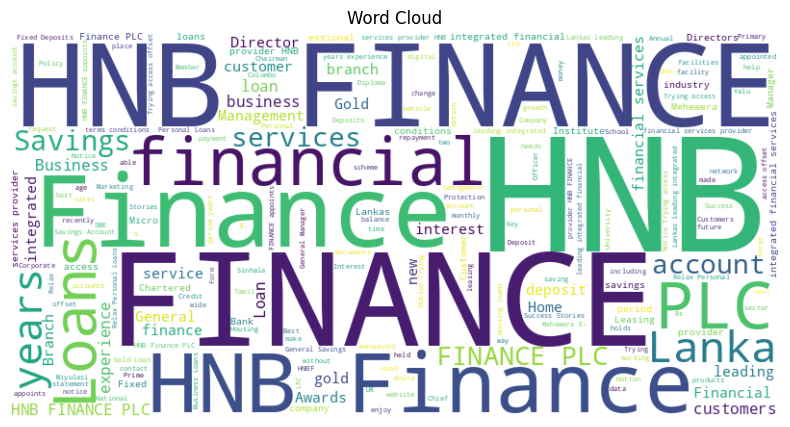

In [ ]:
# Function to generate and display a word cloud using the cleaned text
def generate_word_cloud(text):
    # Tokenize the text to find n-grams
    sentences = text.split('. ')  # Split into sentences for better context
    all_words = []

    for sentence in sentences:
        words = sentence.split()
        all_words.extend(words)  # Collect all words for word frequency analysis

        # Generate bigrams and trigrams
        bi_grams = ngrams(words, 2)
        tri_grams = ngrams(words, 3)

        # Count bigram and trigram frequencies
        all_words += [' '.join(bi) for bi in bi_grams]
        all_words += [' '.join(tri) for tri in tri_grams]

    # Count frequencies
    word_freq = Counter(all_words)

    # Generate word cloud from word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axis
    plt.title("Word Cloud")
    plt.show()

# Generate and display the word cloud for the cleaned text
generate_word_cloud(final_cleaned_text)

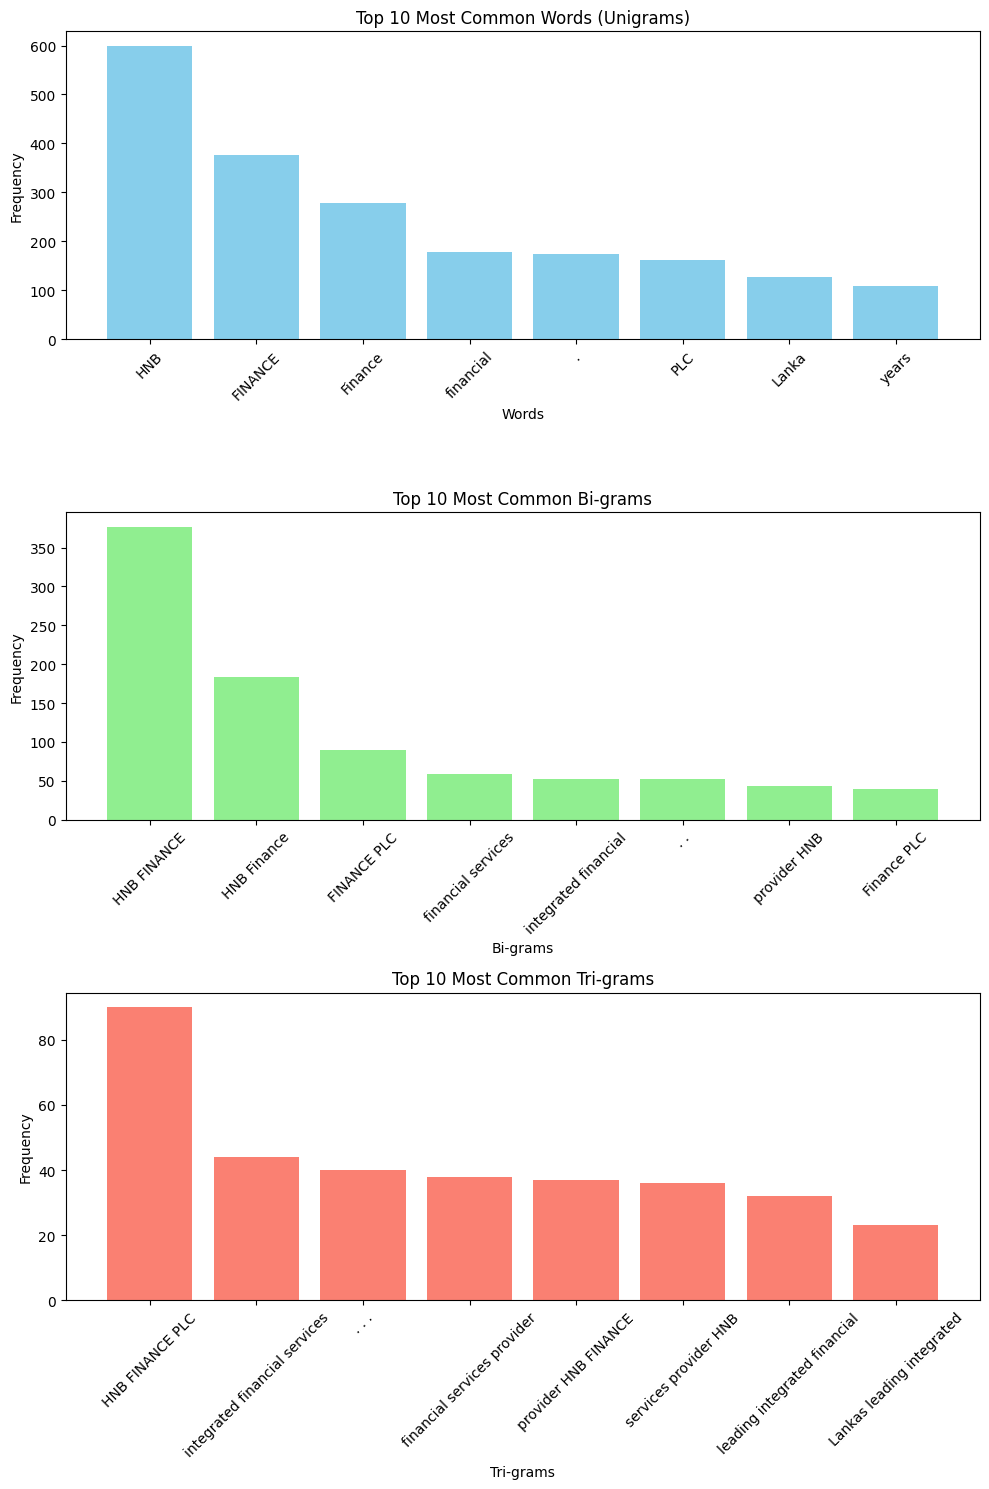

In [ ]:
# Function to plot top words and n-grams
def plot_top_words_n_grams(text):
    # Create n-grams
    words = text.split()
    one_grams = Counter(words)
    bi_grams = Counter(ngrams(words, 2))
    tri_grams = Counter(ngrams(words, 3))

    # Get the most common words, bi-grams, and tri-grams
    most_common_one_grams = one_grams.most_common(8)
    most_common_bi_grams = bi_grams.most_common(8)
    most_common_tri_grams = tri_grams.most_common(8)

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # One-grams
    words, frequencies = zip(*most_common_one_grams)
    axes[0].bar(words, frequencies, color='skyblue')
    axes[0].set_title('Top 10 Most Common Words (Unigrams)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlabel('Words')
    axes[0].set_xticks(range(len(words)))  # Set x-ticks to positions
    axes[0].set_xticklabels(words, rotation=45)

    # Bi-grams
    bi_words, bi_frequencies = zip(*most_common_bi_grams)
    axes[1].bar([' '.join(bi) for bi in bi_words], bi_frequencies, color='lightgreen')
    axes[1].set_title('Top 10 Most Common Bi-grams')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xlabel('Bi-grams')
    axes[1].set_xticks(range(len(bi_words)))  # Set x-ticks to positions
    axes[1].set_xticklabels([' '.join(bi) for bi in bi_words], rotation=45)

    # Tri-grams
    tri_words, tri_frequencies = zip(*most_common_tri_grams)
    axes[2].bar([' '.join(tri) for tri in tri_words], tri_frequencies, color='salmon')
    axes[2].set_title('Top 10 Most Common Tri-grams')
    axes[2].set_ylabel('Frequency')
    axes[2].set_xlabel('Tri-grams')
    axes[2].set_xticks(range(len(tri_words)))  # Set x-ticks to positions
    axes[2].set_xticklabels([' '.join(tri) for tri in tri_words], rotation=45)

    plt.tight_layout()
    plt.show()

# Plot the top words, bi-grams, and tri-grams from the cleaned text
plot_top_words_n_grams(final_cleaned_text)

3. Creating a Financial Vocabluary

In [ ]:
import json

# Define the banking vocabulary structure as a dictionary
banking_data = [

        "Savings Account", "Current Account", "Fixed Deposit", "Loan", "Mortgage", "Overdraft", "ATM",
        "Cheque", "Credit Card", "Debit Card", "Branch", "Bank Statement", "Interest Rate", "Bank Charges",
        "Loan Repayment", "Personal Loan", "Business Loan", "Housing Loan", "Car Loan", "Insurance", "Investment",
        "Bonds", "Stocks", "Equity", "Mutual Funds", "Futures", "Derivatives", "Treasury", "Financial Planning",
        "Wealth Management", "Corporate Banking", "Retail Banking", "Investment Banking", "Digital Banking",
        "Mobile Banking", "E-wallet", "Online Banking", "Cross-border Payments", "Foreign Currency Exchange",
        "Money Market", "Capital Markets", "Currency Exchange", "Trade Finance", "Securities", "Financial Inclusion",
        "Credit Risk", "Operational Risk", "Financial Statements", "Taxation", "Corporate Governance",
        "Anti-Money Laundering", "KYC", "AML (Anti Money Laundering)", "Sustainability", "Green Banking",
        "Digital Payments", "Cash Flow", "Asset Management", "Financial Advisor", "Custodian Bank",
        "Financial Technology (Fintech)", "Blockchain", "Cryptocurrency","Bank of Ceylon", "People's Bank", "Hatton National Bank",
        "Commercial Bank of Ceylon", "Sampath Bank","DFCC Bank", "National Savings Bank", "Seylan Bank", "Ceylon Bank", "Lanka Commercial Bank",
        "BOC", "HNB", "CBC", "DFCC", "NSB",
        "Personal Banking", "Corporate Banking", "Retail Banking", "Home Loans", "Car Loans", "Personal Loans",
        "Business Loans", "Mortgage Loans", "Fixed Deposits", "Current Accounts", "Savings Accounts", "Credit Cards",
        "Debit Cards", "Investment Advisory Services", "Insurance Products", "Wealth Management", "Asset Management",
        "Trade Finance", "Foreign Exchange Services", "Remittance Services", "Mobile Banking", "Online Banking",
        "E-Wallets", "ATMs", "POS Solutions", "Microfinance", "Venture Capital Financing", "Securities Trading",
        "Mutual Funds", "Digital Banking Solutions", "Treasury Services", "Cash Management Solutions",
        "Green Banking Products", "Corporate Finance Services", "Deposit Insurance", "SME Financing"

]

# Save the list to a JSON file
with open('sri_lankan_banking_financial_vocabulary.json', 'w') as f:
    json.dump(banking_data, f, indent=4)

4. KeyBERT

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from a CSV file
csv_file_path = "/content/new_keyword_dataset.csv"  # Update with your actual file path
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset to ensure it's loaded correctly
print(data.head())

# Convert the 'Keywords' column from a string to a list
data['Keywords List'] = data['Keywords List'].apply(lambda x: x.split(','))

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract Articles and Keywords for training
articles = train_data['Sentence'].tolist()
target_keywords = train_data['Keywords List'].tolist()

# Display the number of training and validation examples
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")

                                            Sentence  \
0  Services Offer Convenience Flexibility Leasing...   
1  Products Help Grow Shaping future products enc...   
2  HNB FINANCE immense strength lives HNB FINANCE...   
3  The fund maintained financial contribution ded...   
4  Explore HNB Finance creates oasis Mohoththuwar...   

                                       Keywords List  
0  ['loans', 'services', 'fixed deposits', 'hnb f...  
1  ['products','hnb finance', 'HNB finance genera...  
2  ['hnb finance', 'money', 'swashakthi savings',...  
3  ['fund', 'fund maintained', 'financial contrib...  
4  ['hnb finance', 'Mohoththuwarama Primary Schoo...  
Number of training examples: 320
Number of validation examples: 80


Extracting Keywords from base KeyBERT Model

In [ ]:
from keybert import KeyBERT
import json

# Initialize KeyBERT model
kw_model = KeyBERT()

# Function to extract unique keywords and keyphrases with scores using KeyBERT
def extract_unique_keywords(text, stop_words='english'):
    # Extract keywords/keyphrases with their scores focusing on bi-grams and tri-grams
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 3), stop_words=stop_words, top_n=200)  # Extract top 200

    # Use a dictionary to keep unique phrases with the highest scores
    unique_keywords = {}

    for keyword, score in keywords:
        if keyword not in unique_keywords or score > unique_keywords[keyword]:
            unique_keywords[keyword] = score

    # Return unique keywords as a sorted list of tuples
    return unique_keywords

# Extract unique keywords and keyphrases with scores from the cleaned text
unique_keywords_with_scores = extract_unique_keywords(final_cleaned_text)

# Display the top 20 keywords and phrases with scores
print("\nTop 20 Unique Keywords and Key Phrases with Scores:")
for i, (phrase, score) in enumerate(sorted(unique_keywords_with_scores.items(), key=lambda x: x[1], reverse=True)[:20]):
    print(f"{i+1}. {phrase}: Score={score:.4f}")

# Save all unique keywords to a JSON file without scores
output_data = list(unique_keywords_with_scores.keys())  # Extract only the keywords

with open('extracted_unique_keywords.json', 'w') as json_file:
    json.dump(output_data, json_file, indent=4)

print("Extracted unique keywords and key phrases saved to 'extracted_unique_keywords.json'.")



Top 20 Unique Keywords and Key Phrases with Scores:
1. services hnb finance: Score=0.7032
2. hnb provide financial: Score=0.7001
3. savings hnb finance: Score=0.6998
4. hnb finance assist: Score=0.6983
5. hnb finance savings: Score=0.6976
6. hnb finance inspire: Score=0.6968
7. fund hnb finance: Score=0.6950
8. hnb finance fortifies: Score=0.6945
9. experience hnb finance: Score=0.6928
10. use hnb finance: Score=0.6922
11. financial solution hnb: Score=0.6902
12. hnb finance achieve: Score=0.6900
13. create hnb finance: Score=0.6896
14. hnb finance serves: Score=0.6874
15. hnb finance lankas: Score=0.6864
16. hnb finance nivahana: Score=0.6860
17. hnb finance equipped: Score=0.6855
18. financial hnb finance: Score=0.6848
19. ensuring hnb finance: Score=0.6848
20. bringing hnb finance: Score=0.6845
Extracted unique keywords and key phrases saved to 'extracted_unique_keywords.json'.


Fine Tune KeyBERT

In [ ]:
# Import necessary libraries
from datasets import load_dataset, Dataset
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)

# Load BERT model
tokenizer = AutoTokenizer.from_pretrained("yanekyuk/bert-uncased-keyword-extractor")
model = AutoModelForTokenClassification.from_pretrained("yanekyuk/bert-uncased-keyword-extractor")

# Function to tokenize and prepare data
def preprocess_data(row):
    # tokenize
    tokenized = tokenizer(row["Sentence"], padding="max_length", truncation=True, max_length=128)
    input_ids = torch.tensor(tokenized["input_ids"])
    attention_mask = torch.tensor(tokenized["attention_mask"])

    # masked tokens and labels
    inputs, labels = mask_tokens(input_ids, tokenizer)
    return {"input_ids": inputs.tolist(), "attention_mask": attention_mask.tolist(), "labels": labels.tolist()}

# Function to create masked tokens
def mask_tokens(inputs, tokenizer):

    labels = inputs.clone()  # Clone inputs for labels

    # Create a probability matrix for masking
    probability_matrix = torch.full(labels.shape, 0.15)  # 15% probability of masking
    special_tokens_mask = tokenizer.get_special_tokens_mask(inputs.tolist(), already_has_special_tokens=True)
    special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
    probability_matrix.masked_fill_(special_tokens_mask, value=0.0)  # Do not mask special tokens
    masked_indices = torch.bernoulli(probability_matrix).bool()

    labels[~masked_indices] = -100  # Tokens not masked are ignored in loss calculation
    inputs[masked_indices] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)  # Replace masked tokens with [MASK]

    return inputs, labels

# Convert DataFrames to Hugging Face Datasets
train_hf_dataset = Dataset.from_pandas(train_data)
val_hf_dataset = Dataset.from_pandas(val_data)

# Tokenize and process the datasets
tokenized_train_dataset = train_hf_dataset.map(preprocess_data, batched=False)
tokenized_val_dataset = val_hf_dataset.map(preprocess_data, batched=False)

# Define the MLM data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# Load BERT model for masked language modeling
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    save_steps=500,
    logging_dir="./logs",
    logging_steps=10,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,  # Use validation dataset for evaluation
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_keybert")
tokenizer.save_pretrained("./fine_tuned_keybert")

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-a66c791e7049>:79: FutureWarning: `tokenizer` is deprecated and will 

('./fine_tuned_keybert/tokenizer_config.json',
 './fine_tuned_keybert/special_tokens_map.json',
 './fine_tuned_keybert/vocab.txt',
 './fine_tuned_keybert/added_tokens.json',
 './fine_tuned_keybert/tokenizer.json')

Extracting keywords from fine tuned keyBERT Model

In [ ]:
# Import necessary libraries
from keybert import KeyBERT
import json
from transformers import AutoTokenizer, AutoModel

# Load the fine-tuned model
fine_tuned_model_path = "./fine_tuned_keybert"  # Path to your fine-tuned model
model = AutoModel.from_pretrained(fine_tuned_model_path)

# Initialize KeyBERT model with your fine-tuned model
kw_model = KeyBERT(model=model)

# Function to extract unique keywords and keyphrases with scores using KeyBERT
def extract_unique_keywords(text, stop_words='english'):
    # Extract keywords/keyphrases with their scores focusing on bi-grams and tri-grams
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words=stop_words, top_n=200)  # Extract top 200

    # Use a dictionary to keep unique phrases with the highest scores
    unique_keywords = {}

    for keyword, score in keywords:
        if keyword not in unique_keywords or score > unique_keywords[keyword]:
            unique_keywords[keyword] = score

    # Return unique keywords as a sorted list of tuples
    return unique_keywords


# Extract unique keywords and keyphrases with scores from the cleaned text
unique_keywords_with_scores = extract_unique_keywords(final_cleaned_text)

# Display the top 20 keywords and phrases with scores
print("\nTop 20 Unique Keywords and Key Phrases with Scores:")
for i, (phrase, score) in enumerate(sorted(unique_keywords_with_scores.items(), key=lambda x: x[1], reverse=True)[:20]):
    print(f"{i+1}. {phrase}: Score={score:.4f}")

# Save all unique keywords to a JSON file without scores
output_data = list(unique_keywords_with_scores.keys())  # Extract only the keywords

with open('keyBERT_keywords.json', 'w') as json_file:
    json.dump(output_data, json_file, indent=4)

print("Extracted unique keywords and key phrases saved to 'keyBERT_keywords.json'.")


Some weights of BertModel were not initialized from the model checkpoint at ./fine_tuned_keybert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Top 20 Unique Keywords and Key Phrases with Scores:
1. loan hnb: Score=0.6442
2. hnb finance: Score=0.6040
3. finance hnb: Score=0.5991
4. borrower hnb: Score=0.5955
5. company loan: Score=0.5893
6. hnb financial: Score=0.5771
7. financial hnb: Score=0.5726
8. leasing hnb: Score=0.5661
9. deposit hnb: Score=0.5586
10. loan service: Score=0.5584
11. loan personal: Score=0.5577
12. finance managing: Score=0.5525
13. financing service: Score=0.5524
14. loan hatton: Score=0.5519
15. loaning facility: Score=0.5512
16. bank hnb: Score=0.5508
17. loan community: Score=0.5497
18. strategic lending: Score=0.5494
19. various loaning: Score=0.5488
20. loan business: Score=0.5471
Extracted unique keywords and key phrases saved to 'keyBERT_keywords.json'.


5. RAKE

In [ ]:
from rake_nltk import Rake
import json

# Initialize RAKE
r = Rake()

# Extract keywords
r.extract_keywords_from_text(final_cleaned_text)

# Get ranked keywords with scores
ranked_keywords_with_scores = r.get_ranked_phrases_with_scores()

# Use a dictionary to remove duplicates and prioritize higher scores
unique_keywords = {}
for score, keyword in ranked_keywords_with_scores:
    if keyword not in unique_keywords or unique_keywords[keyword] < score:
        unique_keywords[keyword] = score

# Filter keywords with a maximum length of 3 words
filtered_keywords = {kw: score for kw, score in unique_keywords.items() if len(kw.split()) <= 3}

# Sort the filtered keywords by score in descending order
sorted_keywords = sorted(filtered_keywords.items(), key=lambda x: x[1], reverse=True)

# Get the first 100 highest-scoring keywords
top_100_keywords = sorted_keywords[:100]

# Prepare the list of keywords for JSON output
keywords_list = [keyword for keyword, score in top_100_keywords]

# Save the results to a JSON file
with open("rake_keywords.json", "w") as json_file:
    json.dump(keywords_list, json_file, indent=4)

# Display the top 100 keywords
print("RAKE - Keywords")
for keyword in top_100_keywords:
    print(f"{keyword[0]} - Score: {keyword[1]}")


RAKE - Keywords
services offer leasing - Score: 116.7124101713654
recent banks statements - Score: 107.85897435897435
hnb finance leasing - Score: 99.16365568280482
business finance university - Score: 92.56730335630999
auto loan - Score: 91.96949152542373
moneygram receive form - Score: 91.76061776061776
obtained mba cardiff - Score: 91.49999999999999
deputy merged entity - Score: 90.38888888888889
abeysekara deputy chief - Score: 89.959477124183
hnb finance plc - Score: 88.47585160924993
new deposit account - Score: 88.37873754152824
relax personal loans - Score: 86.08851750537222
acuity partners pvt - Score: 85.05580693815988
fees charged period - Score: 84.81951219512194
top financial new - Score: 84.53425760286225
repayments two years - Score: 83.55310049893086
hnb hnb hnb - Score: 83.46000000000001
holds mba merit - Score: 82.99999999999999
nivahana housing loans - Score: 82.44592541436464
business loan whether - Score: 82.30598100493646
importance housing loans - Score: 80.55009

Approach Combination - Scoring Scheme

In [ ]:
import json

if isinstance(final_cleaned_text, list):
    final_cleaned_text = ' '.join(final_cleaned_text)

# Load JSON files
with open('word_frequencies.json', 'r') as file:
    word_frequencies = json.load(file)

with open('keyBERT_keywords.json', 'r') as file:
    extracted_keywords = json.load(file)

with open('sri_lankan_banking_financial_vocabulary.json', 'r') as file:
    financial_vocabulary = json.load(file)

with open('ner_unique_words.json', 'r') as file:
    unique_words = json.load(file)

with open('rake_keywords.json', 'r') as file:
    rake_keywords = json.load(file)

# Scraped content for checking occurrences
scraped_content = final_cleaned_text

# Initialize a dictionary to store keyword scores
keyword_scores = {}
keyword_sources = {}

# Function to update scores and track keyword sources
# Function to check presence of keywords and update scores
def update_scores(keyword_list, base_score, source_name):
    for keyword in keyword_list:
        if isinstance(keyword, str) and keyword.lower() in scraped_content.lower():  # Ensure keyword is a string
            if keyword not in keyword_scores:
                keyword_scores[keyword] = base_score
            else:
                keyword_scores[keyword] += base_score

# Scoring weights for each method
scores = {
    "financial_vocabulary": 5,
    "extracted_keywords": 3,
    "rake_keywords": 2,
    "word_frequencies": 1,
    "unique_words": 1,
}

# Update scores using each method
update_scores(financial_vocabulary, scores["financial_vocabulary"], "Financial Vocabulary")
update_scores(rake_keywords, scores["rake_keywords"], "RAKE")
update_scores(extracted_keywords, scores["extracted_keywords"], "KeyBERT")
update_scores(word_frequencies, scores["word_frequencies"], "Word Frequencies")
update_scores(unique_words, scores["unique_words"], "Unique Words")

# bonus points for keywords appearing in multiple methods
for keyword, sources in keyword_sources.items():
    if len(sources) > 1:
        keyword_scores[keyword] += 2 * (len(sources) - 1)  # +2 points each

# Filter keywords that have a score greater than 0
filtered_keywords = {keyword: score for keyword, score in keyword_scores.items() if score > 0}

# Sort keywords by score in descending order
sorted_keywords = sorted(filtered_keywords.items(), key=lambda x: x[1], reverse=True)

# Display the top 1000 keywords and scores
print("\nTop Keywords with Scores:")
for phrase, score in sorted_keywords[:1000]:  # Display top 1000 keywords
    print(f"{phrase}: Score={score}")

# Convert sorted keywords back to a dictionary
ordered_keywords = {keyword: score for keyword, score in sorted_keywords}

# Save ordered keywords with scores to a JSON file
with open('final_keywords_with_scores.json', 'w') as json_file:
    json.dump(ordered_keywords, json_file, indent=4)

print("All keywords with scores saved to 'final_keywords_with_scores.json'.")



Top Keywords with Scores:
Trade Finance: Score=11
Retail Banking: Score=10
Savings Account: Score=6
ATM: Score=6
KYC: Score=6
Hatton National Bank: Score=6
HNB: Score=6
Home Loans: Score=6
Personal Loans: Score=6
Business Loans: Score=6
Current Account: Score=5
Fixed Deposit: Score=5
Loan: Score=5
Mortgage: Score=5
Cheque: Score=5
Credit Card: Score=5
Branch: Score=5
Bank Statement: Score=5
Interest Rate: Score=5
Loan Repayment: Score=5
Personal Loan: Score=5
Business Loan: Score=5
Housing Loan: Score=5
Insurance: Score=5
Investment: Score=5
Financial Planning: Score=5
Capital Markets: Score=5
Securities: Score=5
Financial Inclusion: Score=5
Credit Risk: Score=5
Financial Statements: Score=5
Taxation: Score=5
Corporate Governance: Score=5
Cash Flow: Score=5
Seylan Bank: Score=5
Fixed Deposits: Score=5
Current Accounts: Score=5
Savings Accounts: Score=5
Credit Cards: Score=5
ATMs: Score=5
Deposit Insurance: Score=5
hnb finance leasing: Score=5
hnb finance plc: Score=5
hnb finance: Scor

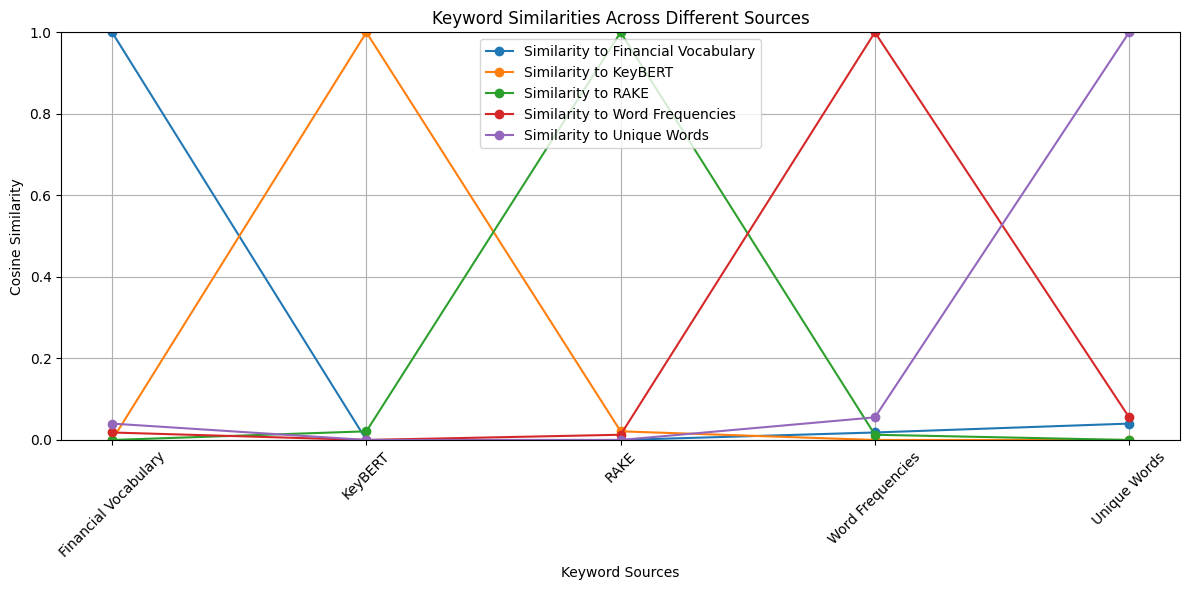

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Load keywords from JSON files
def load_keywords(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Load all keyword sources
word_frequencies = load_keywords('word_frequencies.json')
extracted_keywords = load_keywords('keyBERT_keywords.json')
financial_vocabulary = load_keywords('sri_lankan_banking_financial_vocabulary.json')
unique_words = load_keywords('ner_unique_words.json')
rake_keywords = load_keywords('rake_keywords.json')

# Combine all keywords into a dictionary
keyword_sources = {
    "Financial Vocabulary": financial_vocabulary,
    "KeyBERT": extracted_keywords,
    "RAKE": rake_keywords,
    "Word Frequencies": word_frequencies,
    "Unique Words": unique_words,
}

# Function to flatten the list of lists and remove duplicates
def flatten_and_unique(keyword_lists):
    unique_keywords = set()
    for keywords in keyword_lists:
        if isinstance(keywords, list):  # Check if it's a list
            unique_keywords.update(keywords)  # Add all words to the set
    return list(unique_keywords)

# Function to calculate similarity matrix
def calculate_similarity_matrix(keywords_dict):
    all_keywords = flatten_and_unique(keywords_dict.values())  # Flatten and get unique keywords

    # Create a document-term matrix where each row corresponds to a source and each column to a unique keyword
    document_term_matrix = np.zeros((len(keywords_dict), len(all_keywords)))

    for i, (source, keywords) in enumerate(keywords_dict.items()):
        for keyword in keywords:
            if keyword in all_keywords:
                index = all_keywords.index(keyword)
                document_term_matrix[i][index] = 1  # Count presence of keyword

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(document_term_matrix)

    return all_keywords, similarity_matrix

# Calculate similarity
all_keywords, similarity_matrix = calculate_similarity_matrix(keyword_sources)

# Plot line charts for similarities between each pair of keyword sources
def plot_similarity(similarity_matrix, sources):
    plt.figure(figsize=(12, 6))

    # Create line plots for each source's similarity scores
    for i in range(len(sources)):
        plt.plot(range(len(sources)), similarity_matrix[i], marker='o', label=f'Similarity to {sources[i]}')

    plt.title('Keyword Similarities Across Different Sources')
    plt.xlabel('Keyword Sources')
    plt.ylabel('Cosine Similarity')
    plt.xticks(range(len(sources)), sources, rotation=45)
    plt.ylim(0, 1)  # Set y-axis to 0-1 for cosine similarity
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot similarity
plot_similarity(similarity_matrix, list(keyword_sources.keys()))


KeyBERT with Sentence Embedding

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from a CSV file
csv_file_path = "/content/new_keyword_dataset.csv"  # Update with your actual file path
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset to ensure it's loaded correctly
print(data.head())

# Convert the 'Keywords' column from a string to a list
data['Keywords List'] = data['Keywords List'].apply(lambda x: x.split(','))

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract Articles and Keywords for training
articles = train_data['Sentence'].tolist()
target_keywords = train_data['Keywords List'].tolist()

# Display the number of training and validation examples
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")


                                            Sentence  \
0  Services Offer Convenience Flexibility Leasing...   
1  Products Help Grow Shaping future products enc...   
2  HNB FINANCE immense strength lives HNB FINANCE...   
3  The fund maintained financial contribution ded...   
4  Explore HNB Finance creates oasis Mohoththuwar...   

                                       Keywords List  
0  ['loans', 'services', 'fixed deposits', 'hnb f...  
1  ['products','hnb finance', 'HNB finance genera...  
2  ['hnb finance', 'money', 'swashakthi savings',...  
3  ['fund', 'fund maintained', 'financial contrib...  
4  ['hnb finance', 'Mohoththuwarama Primary Schoo...  
Number of training examples: 320
Number of validation examples: 80


In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from transformers import AdamW

# Initialize KeyBERT with SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
model = KeyBERT(model=embedding_model)

# Fine-tuning process for the embedding model
def fine_tune_embedding_model(embedding_model, articles, target_keywords):
    embedding_model.train()  # Set the model to training mode

    # Initialize optimizer
    optimizer = AdamW(embedding_model.parameters(), lr=1e-5)

    for epoch in range(10):  # Iterate through multiple epochs
        for article, keywords in zip(articles, target_keywords):
            optimizer.zero_grad()  # Zero out gradients

            # Get embeddings for the article and keywords
            article_embedding = embedding_model.encode(article, convert_to_tensor=True)
            keyword_embeddings = embedding_model.encode(keywords, convert_to_tensor=True)

            # Ensure embeddings require gradients
            article_embedding.requires_grad_()
            keyword_embeddings.requires_grad_()

            # Compute cosine similarity
            similarity_scores = torch.nn.functional.cosine_similarity(
                article_embedding.unsqueeze(0),
                keyword_embeddings,
                dim=1
            )

            # Define a loss function to maximize similarity
            loss = -torch.mean(similarity_scores)  # Negative cosine similarity loss

            # Backpropagation and optimization step
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update model parameters

            print(f"Epoch: {epoch}, Loss: {loss.item()}")  # Print loss for tracking

    return embedding_model

# Fine-tune the embedding model
embedding_model = fine_tune_embedding_model(embedding_model, articles, target_keywords)

# Reinitialize KeyBERT with the fine-tuned embedding model
model = KeyBERT(model=embedding_model)



Epoch: 0, Loss: -0.6230663061141968
Epoch: 0, Loss: -0.5471189618110657
Epoch: 0, Loss: -0.46494612097740173
Epoch: 0, Loss: -0.49523741006851196
Epoch: 0, Loss: -0.387713760137558
Epoch: 0, Loss: -0.4795762598514557
Epoch: 0, Loss: -0.48685434460639954
Epoch: 0, Loss: -0.3712886571884155
Epoch: 0, Loss: -0.31869208812713623
Epoch: 0, Loss: -0.5464110374450684
Epoch: 0, Loss: -0.6367314457893372
Epoch: 0, Loss: -0.33395853638648987
Epoch: 0, Loss: -0.47007477283477783
Epoch: 0, Loss: -0.5193935036659241
Epoch: 0, Loss: -0.45670804381370544
Epoch: 0, Loss: -0.4731173515319824
Epoch: 0, Loss: -0.3090229630470276
Epoch: 0, Loss: -0.2149658054113388
Epoch: 0, Loss: -0.43879035115242004
Epoch: 0, Loss: -0.4750271737575531
Epoch: 0, Loss: -0.4663938283920288
Epoch: 0, Loss: -0.4310419261455536
Epoch: 0, Loss: -0.3418690860271454
Epoch: 0, Loss: -0.5128970146179199
Epoch: 0, Loss: -0.5067701935768127
Epoch: 0, Loss: -0.4288179874420166
Epoch: 0, Loss: -0.438544362783432
Epoch: 0, Loss: -0.401

In [ ]:
# Save the embedding model
embedding_model.save_pretrained("fine_tuned_embedding_model")

# Save the KeyBERT model (assuming you've wrapped the embedding model)
import joblib  # You can use pickle, but joblib is better for large numpy arrays
joblib.dump(model, "fine_tuned_keybert_model.pkl")

['fine_tuned_keybert_model.pkl']

In [ ]:
import joblib
from keybert import KeyBERT

# Load the fine-tuned embedding model
from transformers import AutoModel, AutoTokenizer

embedding_model = AutoModel.from_pretrained("fine_tuned_embedding_model")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_embedding_model")

# Load the KeyBERT model
keybert_model = joblib.load("fine_tuned_keybert_model.pkl")

# Function to extract keywords using KeyBERT
def extract_keywords(text, model, num_keywords=100):
    # Extract keywords
    keywords = model.extract_keywords(text, keyphrase_ngram_range=(1, 3), top_n=num_keywords)
    return keywords

# Extract keywords from the example text
keywords = extract_keywords(final_cleaned_text, keybert_model)
print("Extracted Keywords:")
for keyword in keywords:
    print(f"{keyword[0]} (Score: {keyword[1]})")


Extracted Keywords:
services hnb finance (Score: 0.7032)
hnb provide financial (Score: 0.7001)
savings hnb finance (Score: 0.6998)
hnb finance assist (Score: 0.6983)
hnb finance savings (Score: 0.6976)
hnb finance inspire (Score: 0.6968)
fund hnb finance (Score: 0.695)
hnb finance fortifies (Score: 0.6945)
experience hnb finance (Score: 0.6928)
use hnb finance (Score: 0.6922)
financial solution hnb (Score: 0.6902)
hnb finance achieve (Score: 0.69)
create hnb finance (Score: 0.6896)
hnb finance serves (Score: 0.6874)
hnb finance lankas (Score: 0.6864)
hnb finance nivahana (Score: 0.686)
hnb finance equipped (Score: 0.6855)
financial hnb finance (Score: 0.6848)
ensuring hnb finance (Score: 0.6848)
bringing hnb finance (Score: 0.6845)
making hnb finance (Score: 0.6828)
survive hnb finance (Score: 0.6821)
hnb finance financial (Score: 0.6816)
hnb finance experience (Score: 0.6814)
hnb finance plcs (Score: 0.6814)
hnb finance provides (Score: 0.6813)
finance joining hnb (Score: 0.6812)
hnb 

Data Analysis

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('keywords and ner Tags.csv')

# Display the original count of rows in the dataset
print(f"Original Row Count: {len(df)}")


Original Row Count: 1000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import ast

# Load the dataset
df = pd.read_csv('keywords and ner Tags.csv')  # Replace with the actual file name

# Function to safely parse string representations of lists
def safe_literal_eval(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (ValueError, SyntaxError):
        return None  # Return None for problematic rows

# Apply safe parsing to 'Keywords List' and 'entities'
df['Keywords List'] = df['Keywords List'].apply(safe_literal_eval)
df['entities'] = df['entities'].apply(safe_literal_eval)

# Drop rows where 'Keywords List' or 'entities' could not be parsed
df = df.dropna(subset=['Keywords List', 'entities'])

### 1. Data Preprocessing ###

# Handle missing values
df.fillna('', inplace=True)

# Convert sentences to lowercase for consistency
df['Sentence'] = df['Sentence'].str.lower()

# Tokenize sentences (split sentences into words)
df['Tokens'] = df['Sentence'].str.split()

print(df)


                                              Sentence  \
0    services offer convenience flexibility leasing...   
1    products help grow shaping future products enc...   
2    hnb finance immense strength lives hnb finance...   
3    the fund maintained financial contribution ded...   
4    explore hnb finance creates oasis mohoththuwar...   
..                                                 ...   
995  read inquiries leave details call work hours a...   
996  during time first development bank dfcc financ...   
997  the national longterm rating bbb lka stable ou...   
998  postgraduate diploma marketing pgdip national ...   
999  chairman board directors corporate management ...   

                                         Keywords List  \
0    [loans, services, fixed deposits, hnb finance ...   
1    [products, hnb finance, HNB finance general sa...   
2    [hnb finance, money, swashakthi savings, Mehew...   
3      [fund, fund maintained, financial contribution]   
4    [hnb fin

<ipython-input-103-1ce0d54ff2dd>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna('', inplace=True)
<ipython-input-103-1ce0d54ff2dd>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence'] = df['Sentence'].str.lower()
<ipython-input-103-1ce0d54ff2dd>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['

In [ ]:
### 2. Data Analysis ###

# Summary statistics
sentence_lengths = df['Tokens'].apply(len)
num_keywords = df['Keywords List'].apply(len)
num_entities = df['entities'].apply(len)

# Most frequent keywords
all_keywords = [kw for keywords in df['Keywords List'] for kw in keywords]
keyword_counts = Counter(all_keywords)

# Most frequent entity types
all_entity_types = [ent[1] for entities in df['entities'] for ent in entities]
entity_type_counts = Counter(all_entity_types)



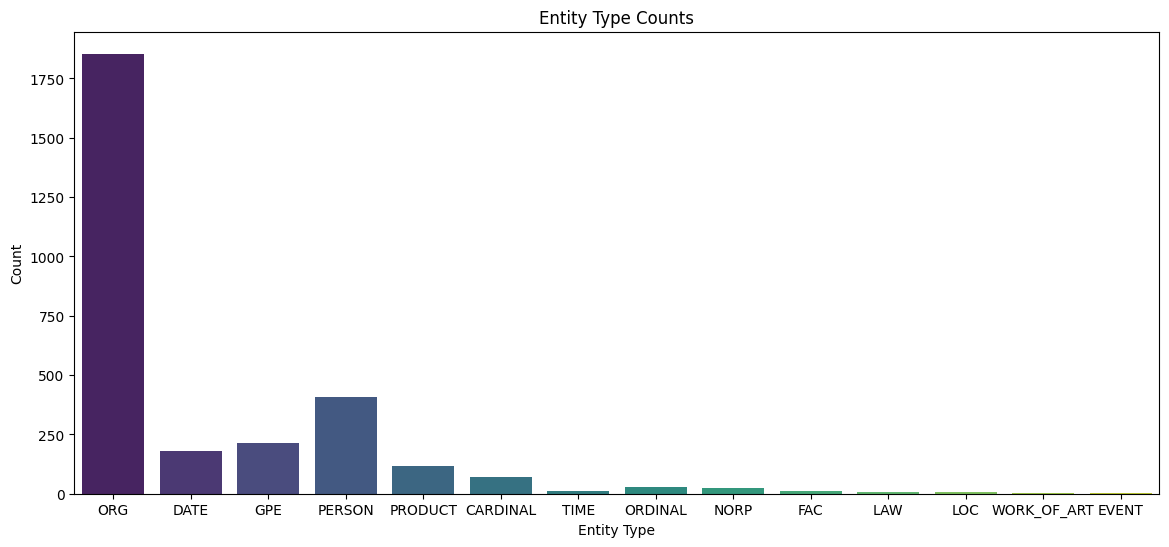

In [ ]:
### 3. Data Visualization ###

# Bar chart for entity types
plt.figure(figsize=(14, 6))
sns.barplot(x=list(entity_type_counts.keys()), y=list(entity_type_counts.values()), palette='viridis')
plt.title("Entity Type Counts")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.show()


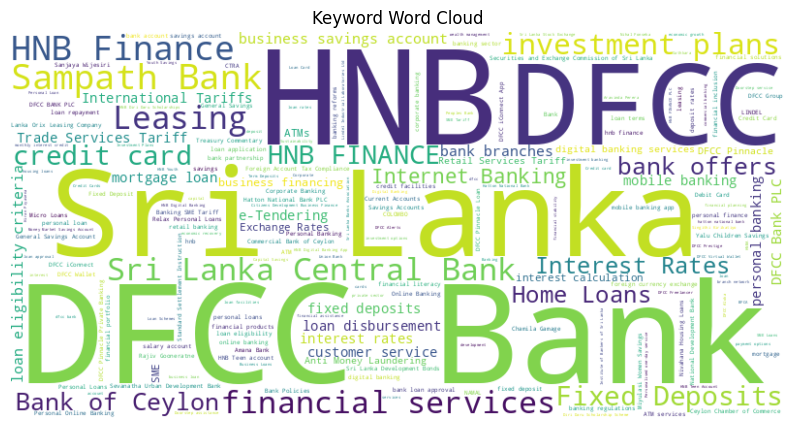

In [ ]:
# Word cloud for keywords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Word Cloud")
plt.show()


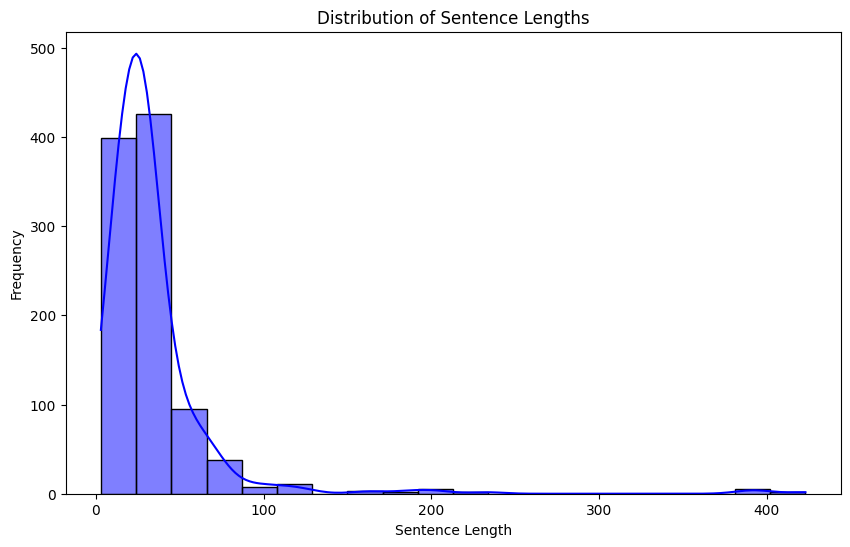

In [ ]:
# Distribution of sentence lengths
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=20, kde=True, color='blue')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:

### Display Most Frequent Keywords ###
print("\nMost Frequent Keywords:")
for keyword, count in keyword_counts.most_common(10):
    print(f"{keyword}: {count}")



Most Frequent Keywords:
DFCC Bank: 73
HNB: 67
Sri Lanka: 55
DFCC: 47
Sampath Bank: 35
HNB Finance: 33
Leasing: 30
financial services: 28
Sri Lanka Central Bank: 28
investment plans: 28


In [ ]:

### Display Entity Type Counts ###
print("\nEntity Type Counts:")
for entity_type, count in entity_type_counts.items():
    print(f"{entity_type}: {count}")


Entity Type Counts:
ORG: 1854
DATE: 179
GPE: 214
PERSON: 408
PRODUCT: 116
CARDINAL: 72
TIME: 13
ORDINAL: 29
NORP: 24
FAC: 12
LAW: 7
LOC: 6
WORK_OF_ART: 3
EVENT: 3


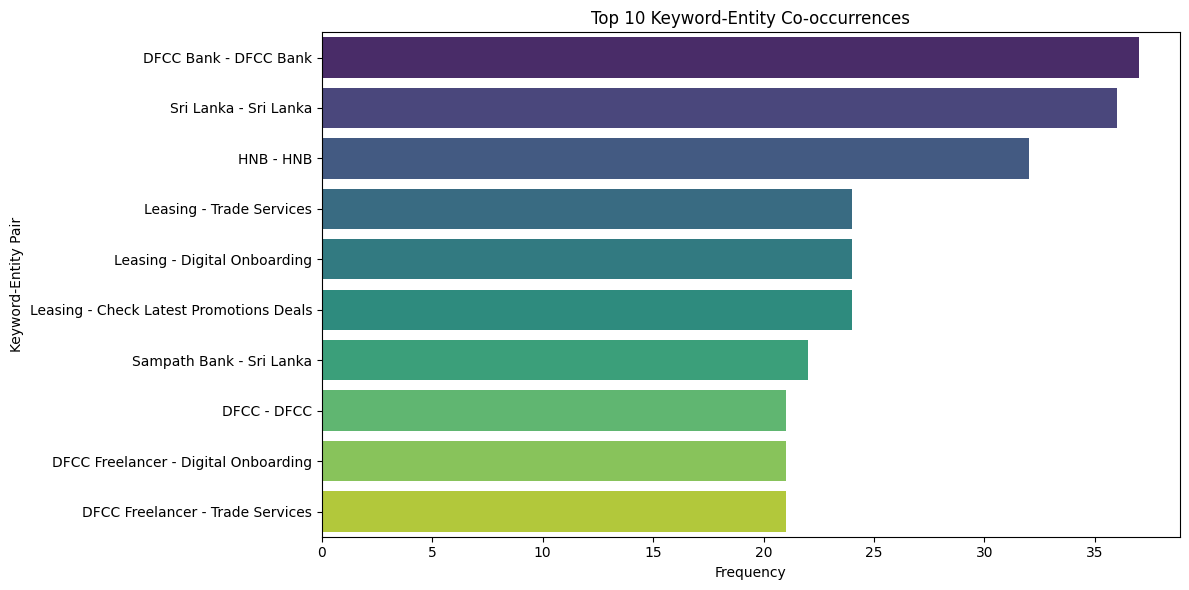

In [ ]:
# Convert the tuple (Keyword, Entity) into a string for visualization
matrix_df['Keyword-Entity Pair'] = matrix_df['Keyword-Entity Pair'].apply(lambda x: f"{x[0]} - {x[1]}")

# Visualize the top 10 co-occurrences
top_cooccurrences = matrix_df.sort_values(by='Frequency', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Keyword-Entity Pair', data=top_cooccurrences, palette='viridis')
plt.title('Top 10 Keyword-Entity Co-occurrences')
plt.xlabel('Frequency')
plt.ylabel('Keyword-Entity Pair')
plt.tight_layout()
plt.show()


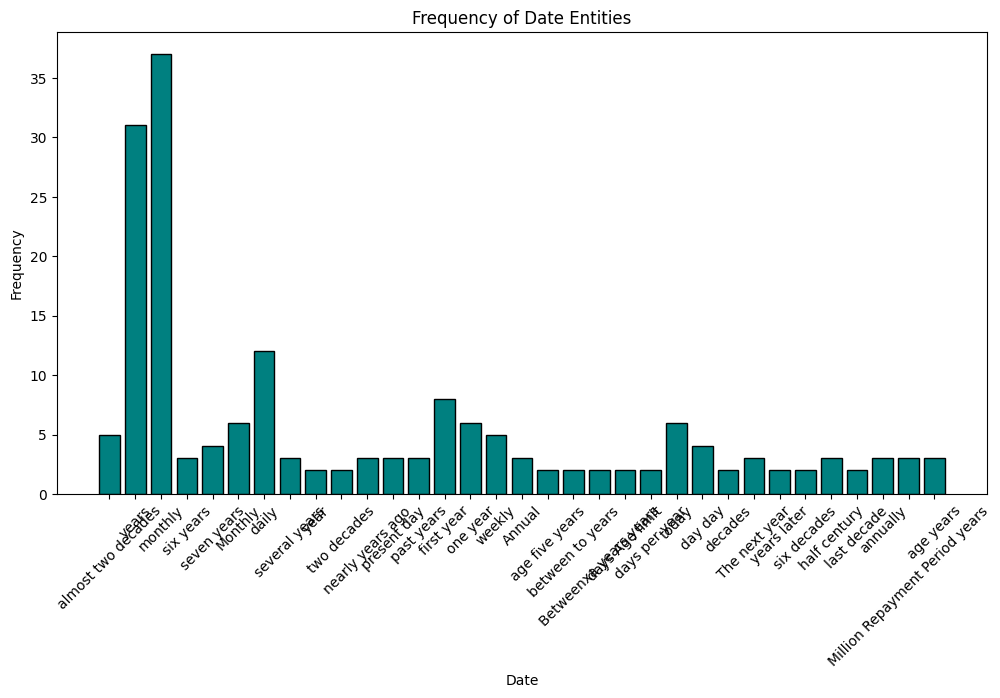

In [ ]:
# Extract and count DATE entities
date_entities = [entity[0] for entities in df['entities'] for entity in entities if entity[1] == 'DATE']
date_freq = Counter(date_entities)

# Plot Date Trends
plt.figure(figsize=(12, 6))
plt.bar(date_freq.keys(), date_freq.values(), color='teal', edgecolor='black')
plt.title('Frequency of Date Entities')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


Data Sample:
'Services That Offer You Convenience and Flexibility Leasing . Fixed Deposits . Savings . Relax - Personal Loans . Micro Loans . Housing Loans . Business Loans . Gold Loans . HNB Finance PLC . Born of . HNB Finance is a subsidiary of Hatton National Bank PLC and continues to operate with an unblemished record of almost two decades as a leader in the finance industry with a diverse portfolio of financial products and services.', "Products to Help You Grow Shaping your future with products that en

Data Length: 237145
Number of Words: 37032
Number of Sentences: 3081


100%|██████████| 1007/1007 [00:10<00:00, 98.47it/s]
<ipython-input-10-7d05a9eb5496>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_type_counts.keys()), y=list(entity_type_counts.values()), palette='viridis')


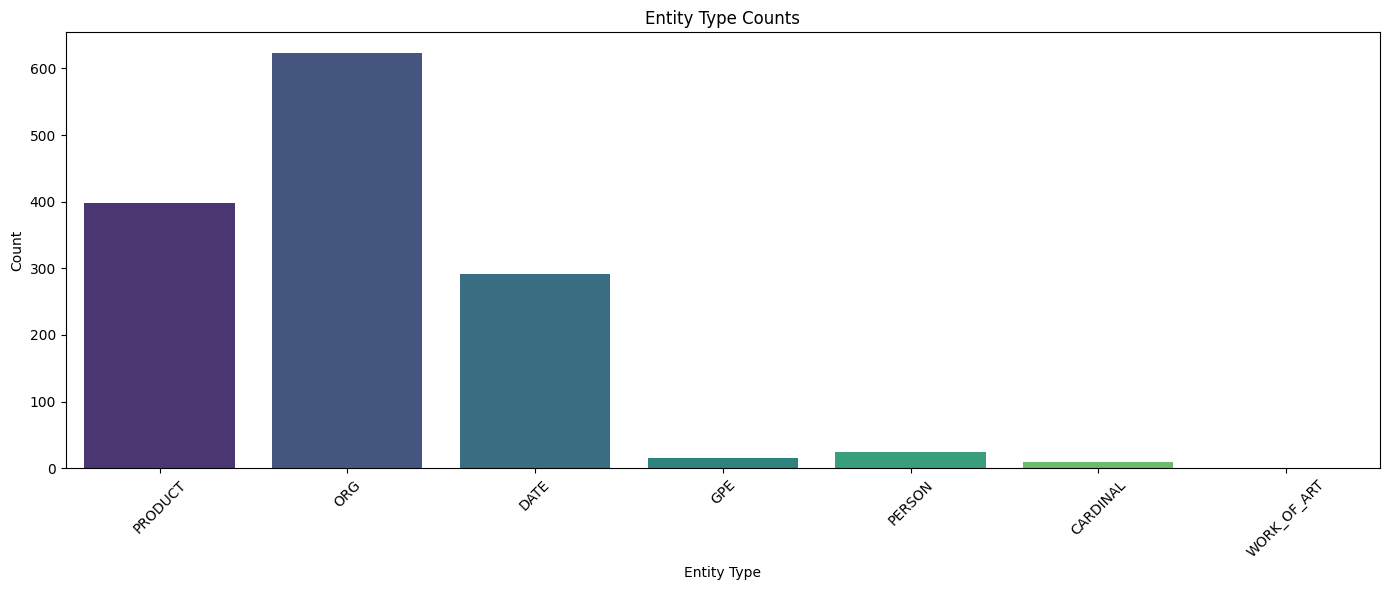

NER results saved to new_ner_results.csv
Workflow completed!


In [ ]:
import spacy
from spacy import displacy
import pandas as pd
from tqdm import tqdm
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the fine-tuned spaCy model
nlp = spacy.load("fine_tuned_model")  # Replace with the path to your fine-tuned model

### 1. Data Analysis ###
def analyze_data(data):
    """
    Analyze the input data to check for missing or unusual patterns.
    """
    print("Data Sample:")
    print(data[:500])  # Show a sample of the data
    print("\nData Length:", len(data))
    print("Number of Words:", len(data.split()))
    print("Number of Sentences:", len(re.split(r'[.!?]', data)))
    return

### 2. Feature Extraction: Tokenization and NER ###
def extract_entities(data, batch_size=10):
    """
    Perform NER on the preprocessed text and extract features.
    """
    # Tokenize and analyze NER in batches for efficiency
    docs = list(tqdm(nlp.pipe(data, batch_size=batch_size), total=len(data)))

    entities = []
    for doc in docs:
        for ent in doc.ents:
            entities.append({"text": ent.text, "label": ent.label_, "start": ent.start_char, "end": ent.end_char})

    return entities

### 3. Data Visualization ###
def visualize_entity_counts(entities):
    """
    Visualize counts of entity types in a bar chart.
    """
    entity_types = [ent['label'] for ent in entities]
    entity_type_counts = Counter(entity_types)

    # Create a bar chart
    plt.figure(figsize=(14, 6))
    sns.barplot(x=list(entity_type_counts.keys()), y=list(entity_type_counts.values()), palette='viridis')
    plt.title("Entity Type Counts")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 4. Exporting Results ###
def export_results(entities, output_file="new_ner_results.csv"):
    """
    Export extracted entities to a CSV file.
    """
    df = pd.DataFrame(entities)
    df.to_csv(output_file, index=False)
    print(f"NER results saved to {output_file}")

### Complete Workflow ###
def ner_workflow(scraped_data):
    """
    Full workflow for processing scraped content with NER.
    """
    # Step 1: Data Analysis
    analyze_data(scraped_data)

    # Step 2: Segment data for large inputs (split by sentences or paragraphs)
    segments = scraped_data.split(". ")

    # Step 3: Extract NER
    entities = extract_entities(segments)

    # Step 4: Visualize Entity Counts
    visualize_entity_counts(entities)

    # Step 5: Save Results
    export_results(entities)

    print("Workflow completed!")
    return

# Run the NER workflow using the fine-tuned model
ner_workflow(clean_text)
